In [1]:
import sys
sys.path.append('../../TINY/')
import TINY 
import UTILS
import load_data_Loader
import SOLVE_EB as EB

import torch
from torch.utils.data import DataLoader
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import math

In [2]:
device = torch.device("cuda")

In [3]:
layer_name = {1 : 'L', 
              2 : 'L', 
              3 :'L'}
skeleton = {0: {}, 
            1 : {'size' : 5}, 
            2 : {'size' : 5}, 
            3 : {'size' : 10}}

In [4]:
fct = {depth : torch.nn.ReLU() for depth in range(1, 3)}
fct.update({3 : torch.nn.Identity()})

In [5]:
def Loss_entropy(x1, x2, reduction = 'mean') :
    return(torch.nn.CrossEntropyLoss(reduction = reduction)(x1, x2))

In [6]:
dico_parameters = {
                 'skeleton' : copy.deepcopy(skeleton),
                'Loss' : Loss_entropy,
                'fct' : fct,
                'layer_name' :layer_name,
                'init_deplacement' : 1e-8, # min amplitude factor
                'batch_size' : 64,# batchsize for training
                'lr' : 1e-2,# leraning rate for training
                'lambda_method' : 0, # = 0 for searching the amplitude factor, if > 0 the 
                                     # amplitude factor is automatically set to this value
                'accroissement_decay' : 1e-4,# the minimum decay to update the 
                                             # architecture with the NewNeurons/BestUpdate 
                'depth_seuil' : {1 : 10, 2 : 10},
                'lu_lin' : 2,
                'max_batch_estimation' : 100,
                'max_amplitude' : 20., # max amplitude factor
                'ind_lmbda_shape' : 1000,
                'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze them
                'len_train_dataset' : 50000, # size of training data
                'len_test_dataset' : 10000, # size of testing data
                'selection_neuron' : UTILS.selection_neuron_seuil,
                'how_to_define_batchsize' : UTILS.indices_non_constant,
                }


In [7]:
MLP_model = TINY.TINY(dico_parameters)

After layer 1 : x.shape=torch.Size([1, 5])
After layer 2 : x.shape=torch.Size([1, 5])
After layer 3 : x.shape=torch.Size([1, 10])
Time to build the model: 0.13 seconds


In [8]:
MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.max_batch_estimation)


In [9]:
MLP_model.tr_loader = DataLoader(MLP_model.training_data, 
                                 batch_size=MLP_model.batch_size,
                                 shuffle=True)
MLP_model.te_loader = DataLoader(MLP_model.test_data, 
                                 batch_size=MLP_model.batch_size, 
                                 shuffle=True)

In [10]:
X, Y = MLP_model.get_batch(data = 'tr', device = device) # parametres par défault
X_te, Y_te =  MLP_model.get_batch(data = 'te', device = device)

In [11]:
with torch.no_grad() :
    print('Loss on train :', MLP_model.Loss(Y, MLP_model(X)).item(), ' || Loss on test :', MLP_model.Loss(Y_te, MLP_model(X_te)).item())
    print('Accuracy on train :', UTILS.calculate_accuracy(Y, MLP_model(X)), ' || Accuracy on test :', UTILS.calculate_accuracy(Y_te, MLP_model(X_te)))

Loss on train : -0.3761349320411682  || Loss on test : -0.46818262338638306
Accuracy on train : 0.09375  || Accuracy on test : 0.0625


In [12]:
optimizer = torch.optim.SGD(MLP_model.parameters(), lr = 1e-4)
L_tr, L_te, _, A_tr, A_te, _, T = MLP_model.train_batch(optimizer = optimizer, nbr_epoch = 0.01)

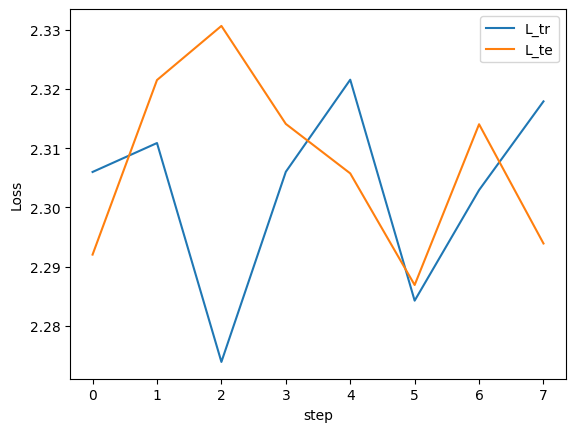

In [13]:
plt.plot(L_tr, label = 'L_tr')
plt.plot(L_te, label = 'L_te')
plt.xlabel('step')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Growth

In [14]:
df_tracker = pd.DataFrame()
A_tr, A_te, L_tr, L_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])
to_add = [1, 2] ##  depth where neurons can be added
nbr_pass = 20
nbr_epochs_betw_adding = 0.5 ## Epochs of training between adding

name_file_expe = 'resultats/' 

In [15]:
def update_quantity_of_interest() :
    global L_tr, L_te, A_tr, A_te, T, df_tracker
    dico_tracker = {'vps' + str(i) : [ MLP_model.valeurs_propres[i].item()] for i in range(len(MLP_model.valeurs_propres))}
    
    dico_tracker.update({'depth_add' : best_depth, 'nbr_added_neuron': MLP_model.nbr_added_neuron})
    dico_tracker.update({'accroissement' : [dico_EB[best_depth]['accroissement']], 'portion_gain' : [dico_EB[best_depth]['portion_gain']],
                        'nbr_parameters_apres' : [MLP_model.count_parameters()], 'nbr_parameters_avant' : [nbr_parameters_avant],
                        'T' : [T[-1]], 'len_L_tr' : [len(L_tr)], 'lu_conv' : [MLP_model.lu_conv]})
    
    df_tracker = pd.concat([df_tracker, pd.DataFrame.from_dict(dico_tracker)], ignore_index=True)
    
    L_tr = np.concatenate([L_tr, l_tr])
    L_te = np.concatenate([L_te, l_te])
    A_tr = np.concatenate([A_tr, a_tr])
    A_te = np.concatenate([A_te, a_te])
    T = np.concatenate([T, t +  T[-1]])

    
    
def stabilize_training() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [16]:
MLP_model.skeleton

{0: {'size': 784}, 1: {'size': 5}, 2: {'size': 5}, 3: {'size': 10}}

In [17]:
count = 1

In [18]:
for j in tqdm(range(5)) :
    for k in range(len(to_add)) :
        nbr_parameters_avant = MLP_model.count_parameters()
        gc.collect()
        torch.cuda.empty_cache()
        depth_ajout = to_add
        depth_in_decreasing_criterion, dico_EB = EB.where_is_EB_best_solved(MLP_model, depths = depth_ajout)

        best_depth = depth_in_decreasing_criterion[0]
        dico_EB_bd = dico_EB[best_depth]
        alpha, omega, bias_alpha, vps = dico_EB_bd['alpha'], dico_EB_bd['omega'], dico_EB_bd['bias_alpha'], dico_EB_bd['vps']
        lambda_method = dico_EB_bd['beta_min']

        MLP_model.alpha, MLP_model.omega, MLP_model.bias_alpha, MLP_model.valeurs_propres = None, None, None, []
        MLP_model.TAB_Add = None

        
        if lambda_method > 0 :
            MLP_model.dico_w, MLP_model.lambda_method = dico_EB_bd['dico_w'], dico_EB_bd['beta_min']
            EB.add_neurons(MLP_model, best_depth, alpha = alpha, omega = omega, bias_alpha = bias_alpha, valeurs_propres = vps)
            MLP_model.lambda_method = torch.tensor(0., device = device)
        
        # Training Loops
        stabilize_training()
        MLP_model.tr_loader = DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True)
        MLP_model.te_loader = DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)
        optimizer = torch.optim.SGD(MLP_model.parameters(), lr = MLP_model.lr)
        
        l_tr, l_te, l_va, a_tr, a_te, a_va, t = MLP_model.train_batch(nbr_epochs_betw_adding, optimizer = optimizer)
        
        # Update results storage
        update_quantity_of_interest()
    
    df_performance = pd.DataFrame.from_dict({'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:], 
                                             'BatchSize' : np.ones(A_te.shape) * MLP_model.batch_size})
    df_tracker.to_csv(name_file_expe + '/df_tracker.csv')
    df_performance.to_csv(name_file_expe + '/df_performance.csv')
    MLP_model.T = T[-1]
    MLP_model.len_L_tr = len(L_tr)
    UTILS.save_model_to_file(MLP_model, path = name_file_expe + '/' , name='model_' + str((j + 1) * (k + 1)))





  0%|                                                                                            | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 



*** started  Add at  1 ***
Batch size for estimation : 7900
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 -----------------------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ---------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ---------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ---------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}

 ---------------------------------------



*** started  NG at  2 ***
Batch size for estimation : 200
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 5]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 5])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 5]), 3: torch.Size([100, 11])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 5]), 3: torch.Size([100, 11])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 20.82326889038086
norm_x_over_norm_DE_depthp1 :  78.15059661865234
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 0.0, 0.0]  ... [-0.002862691879272461, -0.0038570165634155273, -0.0004597902297973633]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-0

 20%|████████████████▊                                                                   | 1/5 [01:10<04:40, 70.13s/it]



*** started  NG at  2 ***
Batch size for estimation : 400
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ---------------------------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 11]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 16.040157318115234
norm_x_over_norm_DE_depthp1 :  52.16872787475586
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -1.7881393432617188e-07, -2.980232238769531e-07]  ... [-0.11035031080245972, -0.12634623050689697, -0.03375881910324097]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.0078125, 0.015625, 0.03125]
rate of decrease : 0.15353898704051971 ampli_fct : 0.015625 L[0] : 0.8228934407234192


*** started  Add at  2 ***
Batch size for estimation : 300
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.0436711348593235
norm_x_over_norm_DE_depthp1 :  0.006352357100695372
amplitude factor for the new neurons : 0.015625
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




*** started  NG at  2 ***
Batch size for estimation : 7

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 15])}
Global variable: outputs
ke

*** SINGULAR MATRIX ***


*** started  Add at  2 ***
Batch size for estimation : 300
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 15]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 15]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 15]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: 

 40%|█████████████████████████████████▌                                                  | 2/5 [02:17<03:26, 68.67s/it]



*** started  NG at  2 ***
Batch size for estimation : 1100
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 --------------------------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 21])}
Global variable: outputs
keys: 

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [03:29<02:20, 70.26s/it]



*** started  NG at  2 ***
Batch size for estimation : 1600
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 21]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 --------------------------------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 4.763669490814209
norm_x_over_norm_DE_depthp1 :  36.81763458251953
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, 1.4901161193847656e-07]  ... [0.0, 1.4901161193847656e-07]
betas :  [0.0, 7.450580596923828e-09] ... [0.0, 7.450580596923828e-09]
rate of decrease : 0.0 ampli_fct : 0.0 L[0] : 0.41356316208839417


*** started  NG at  3 ***
Batch size for estimation : 700
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 31])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
sh



*** started  NG at  2 ***
Batch size for estimation : 2100
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 31]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 --------------------------------------------------------

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 -----------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 28.485387802124023
norm_x_over_norm_DE_depthp1 :  57.86695098876953
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -5.960464477539063e-08, -2.384185791015625e-07]  ... [-0.004128932952880859, -0.00468793511390686, -0.00277024507522583]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.01071346178650856 ampli_fct : 0.0009765625 L[0] : 0.43757426738739014


*** started  NG at  3 ***
Batch size for estimation : 900
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 41])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size(

Delta Loss :  [0.0, -1.1920928955078125e-07, -2.682209014892578e-07]  ... [-0.008061885833740234, -0.011558562517166138, -0.0009476244449615479]
betas :  [0.0, 7.450580596923828e-09, 1.4901161193847656e-08] ... [0.00048828125, 0.0009765625, 0.001953125]
rate of decrease : 0.027339642867445946 ampli_fct : 0.0009765625 L[0] : 0.42277663946151733


*** started  Add at  2 ***
Batch size for estimation : 500
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 1.3364535570144653
norm_x_over_norm_DE_depthp1 :  0.02013714797794819
amplitude factor for the new neurons : 0.0009765625
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  2 ***




 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [04:52<01:15, 75.28s/it]



*** started  NG at  2 ***
Batch size for estimation : 2600
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 41]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 --------------------------------------------------------

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 -----------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 51])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 51])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 51])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 51])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 51]), 3: torch.Size([100, 10])}

 -----------------------------------

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 -----------------------------------

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2])
shapes: {2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 -----------------------------------

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
ke

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([1, 2])
shapes: {1: torch.Size([100, 784]), 2: torch.Size([100, 25])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 61])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([3])
shapes: {3: torch.Size([100, 61])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

*** SINGULAR MATRIX ***


*** started  Add at  2 ***
Batch size for estimation : 500
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ------------------------------------------------------------ 

Global variable: activity
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 25]), 3: torch.Size([100, 61])}
Global variable: outputs
keys: dict_keys([2, 3])
shapes: {2: torch.Size([100, 61]), 3: torch.Size([100, 10])}

 ---

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:23<00:00, 76.68s/it]


In [19]:
MLP_model.skeleton

{0: {'size': 784}, 1: {'size': 35}, 2: {'size': 61}, 3: {'size': 10}}

In [20]:
path = 'resultats/'
df_tracker = pd.read_csv(path + 'df_tracker.csv')
df_performance = pd.read_csv(path + 'df_performance.csv')

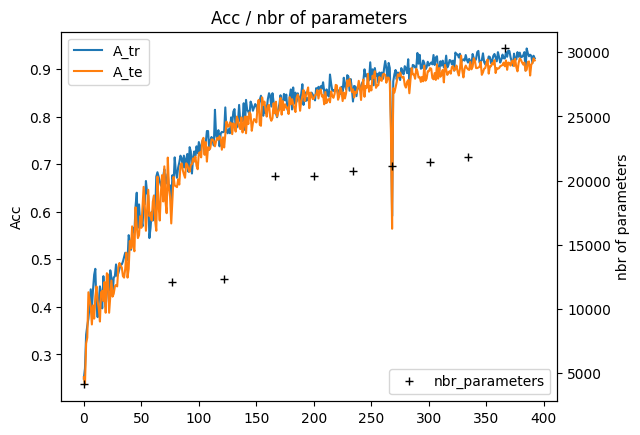

In [21]:
fig, ax = plt.subplots(1, 1)
coef = 5
ax.plot(UTILS.lisser_courbe(df_performance[['A_tr', 'A_te']], coef = coef), label = ['A_tr', 'A_te'])
ax.legend()
ax_nbrp = ax.twinx()
ax_nbrp.plot(df_tracker['len_L_tr'] / coef, df_tracker['nbr_parameters_apres'], '+', label = 'nbr_parameters', color = 'black')
ax_nbrp.legend(loc = 'lower right')
ax.set_title('Acc / nbr of parameters')
ax.set_ylabel('Acc')
ax_nbrp.set_ylabel('nbr of parameters')
plt.show()

In [23]:
l_tr.shape

(137,)